<a href="https://colab.research.google.com/github/tahazz5/prediction_puissance/blob/main/prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# @title  Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense , LSTM
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [ ]:
# @title preprocessing
# Create a MinMaxScaler to normalize data between 0 and 1
SC = MinMaxScaler(feature_range=(0, 1))

# Read data from a CSV file using pandas
data = pd.read_csv('/content/drive/MyDrive/Dataset.csv', sep=";")
data['Date'] = pd.to_datetime(data['Date'], format="%d/%m/%Y %H:%M")

# Define a prediction period with 10 time steps of 10 minutes each
predict_period = pd.date_range(list(data['Date'])[-1], periods=10, freq="10 min")

# Convert comma-separated values to decimal points in columns with object dtype
for colonne in data.columns:
    if data[colonne].dtype == 'object':
        data[colonne] = data[colonne].str.replace(',', '.')

# Replace 'Bad' with NaN in the 'P' column
data['P'].replace('Bad', np.nan, inplace=True)
data['P'].fillna( method ='ffill', inplace = True)
# Normalize the 'P' column using MinMaxScaler
SC_data = SC.fit_transform(data['P'].values.reshape(-1, 1))


In [ ]:
# @title Preparer les entrée du modéle
# Split the data into training and test sets
def divise(SC_data, n):
    train_data, test_data = SC_data[int(len(SC_data) * n):], SC_data[:int(len(SC_data) * n)]
    return train_data, test_data

test_data, train_data = divise(SC_data, 0.8)

# Function to create fixed-length sequences for training and testing
def create_entrer(sc_data, seq_length):
    data = []
    for i in range(len(sc_data) - seq_length):
        data.append(sc_data[i: i + seq_length])
    return np.array(data)

length = 64
X_train = create_entrer(train_data, length)
y_train = train_data[length:]
X_test = create_entrer(test_data, length)
y_test = test_data[length:]


In [ ]:
# @title creation de modéle de neurone LSTM et l'entrainer


# Create a Sequential model with an GRU layer and a Dense layer
model = Sequential()
model.add(LSTM(64, input_shape=(length, 1)))
model.add(Dense(1)) #dimension

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)

Epoch 1/10
1182/1182 [==============================] - 53s 42ms/step - loss: 0.0056 - val_loss: 6.1322e-04
Epoch 2/10
1182/1182 [==============================] - 48s 41ms/step - loss: 8.6164e-04 - val_loss: 2.4096e-04
Epoch 3/10
1182/1182 [==============================] - 49s 42ms/step - loss: 5.9043e-04 - val_loss: 1.6460e-04
Epoch 4/10
1182/1182 [==============================] - 49s 42ms/step - loss: 4.8577e-04 - val_loss: 1.5694e-04
Epoch 5/10
1182/1182 [==============================] - 49s 41ms/step - loss: 4.4315e-04 - val_loss: 2.4454e-04
Epoch 6/10
1182/1182 [==============================] - 51s 43ms/step - loss: 4.2232e-04 - val_loss: 1.2584e-04
Epoch 7/10
1182/1182 [==============================] - 49s 41ms/step - loss: 4.1154e-04 - val_loss: 1.6320e-04
Epoch 8/10
1182/1182 [==============================] - 51s 43ms/step - loss: 4.0260e-04 - val_loss: 1.5959e-04
Epoch 9/10
1182/1182 [==============================] - 49s 42ms/step - loss: 4.0231e-04 - val_loss: 1.1996e

In [ ]:
# @title Évaluation du modèle sur les données de test
eval = model.evaluate(X_test, y_test)
y_pred_test = model.predict(X_test)
# Conversion des prédictions pour qu'elles aient la même forme que y_test (si nécessaire)
y_pred_test = y_pred_test.flatten()
# Calcul des métriques d'évaluation
# MAE pour les données de test
mae_test = mean_absolute_error(y_test, y_pred_test)
# R² pour les données de test
r2_test = r2_score(y_test, y_pred_test)
# MSE pour les données de test
mse_test = mean_squared_error(y_test, y_pred_test)
# RMSE pour les données de test
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)


157/656 [======>.......................] - ETA: 5s - loss: 4.4417e-04

KeyboardInterrupt: ignored

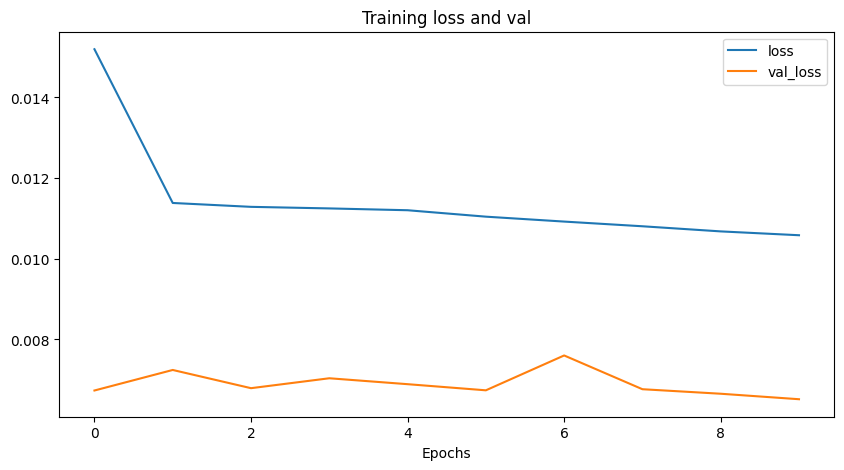

In [ ]:
# @title validation and loss

plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.xlabel('Epochs')
plt.title('Training loss and val')
plt.legend()
plt.show()

In [ ]:
# @title evaluer le modéle et donner les valeurs des métrics
# Evaluate the model on the test data
eval = model.evaluate(X_test, y_test)
y_pred_test = model.predict(X_test)
y_pred_test = y_pred_test.flatten()

# Calculate various evaluation metrics for the test data
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

# Display the evaluation results for the test data
print("MAE (Mean Absolute Error) on test data:", mae_test)
print("R² (Coefficient of determination) on test data:", r2_test)
print("MSE (Mean Squared Error) on test data:", mse_test)
print("RMSE (Root Mean Squared Error) on test data:", rmse_test)
# Perform similar evaluation on the training data
y_pred_train = model.predict(X_train)
y_pred_train = y_pred_train.flatten()
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)

# Display the evaluation results for the training data
print("MAE (Mean Absolute Error) on training data:", mae_train)
print("R² (Coefficient of determination) on training data:", r2_train)
print("MSE (Mean Squared Error) on training data:", mse_train)
print("RMSE (Root Mean Squared Error) on training data:", rmse_train)

656/656 [==============================] - 7s 10ms/step
MAE (Mean Absolute Error) on test data: 0.00478601905435141
R² (Coefficient of determination) on test data: 0.9901952679949704
MSE (Mean Squared Error) on test data: 0.00028527271408926313
RMSE (Root Mean Squared Error) on test data: 0.01689001817906846
2626/2626 [==============================] - 30s 11ms/step
MAE (Mean Absolute Error) on training data: 0.006010578362225972
R² (Coefficient of determination) on training data: 0.995239550262987
MSE (Mean Squared Error) on training data: 0.0003571102352814605
RMSE (Root Mean Squared Error) on training data: 0.01889736053742587


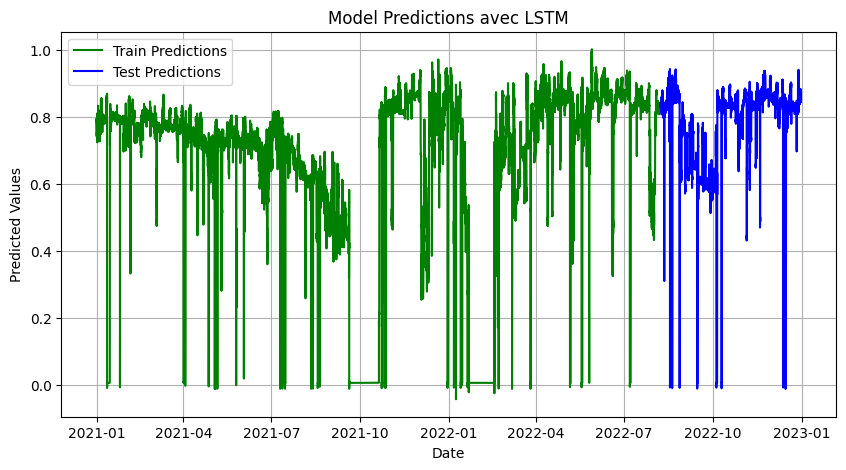

In [ ]:
# @title courbe de prediction
plt.figure(figsize=(10, 5))
plt.plot(data['Date'][:len(y_pred_train)], y_pred_train, color='green', label='Train Predictions')
plt.plot(data['Date'][len(y_pred_train):len(y_pred_train)+len(y_pred_test)], y_pred_test, color='blue', label='Test Predictions')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.title('Model Predictions avec LSTM')
plt.legend()
plt.grid()
plt.show()

[Timestamp('2022-12-31 15:50:00', freq='10T'), Timestamp('2022-12-31 16:00:00', freq='10T'), Timestamp('2022-12-31 16:10:00', freq='10T'), Timestamp('2022-12-31 16:20:00', freq='10T'), Timestamp('2022-12-31 16:30:00', freq='10T'), Timestamp('2022-12-31 16:40:00', freq='10T'), Timestamp('2022-12-31 16:50:00', freq='10T'), Timestamp('2022-12-31 17:00:00', freq='10T'), Timestamp('2022-12-31 17:10:00', freq='10T'), Timestamp('2022-12-31 17:20:00', freq='10T'), Timestamp('2022-12-31 17:30:00', freq='10T'), Timestamp('2022-12-31 17:40:00', freq='10T'), Timestamp('2022-12-31 17:50:00', freq='10T'), Timestamp('2022-12-31 18:00:00', freq='10T'), Timestamp('2022-12-31 18:10:00', freq='10T'), Timestamp('2022-12-31 18:20:00', freq='10T'), Timestamp('2022-12-31 18:30:00', freq='10T'), Timestamp('2022-12-31 18:40:00', freq='10T'), Timestamp('2022-12-31 18:50:00', freq='10T'), Timestamp('2022-12-31 19:00:00', freq='10T'), Timestamp('2022-12-31 19:10:00', freq='10T'), Timestamp('2022-12-31 19:20:00', 

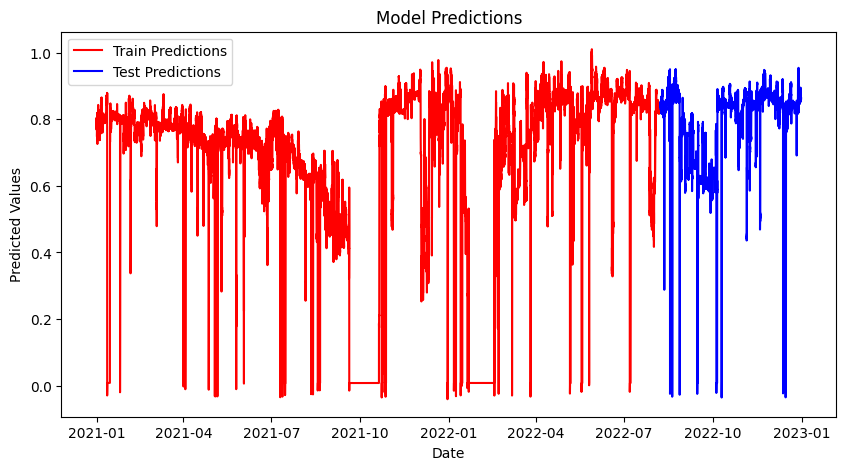

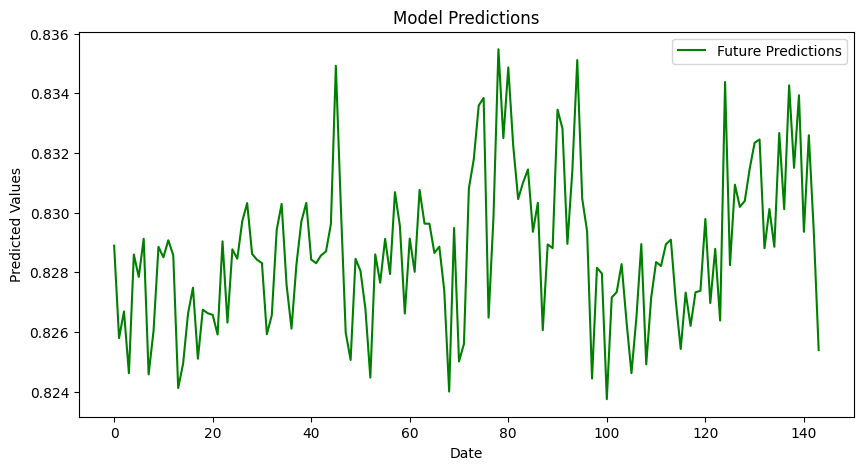

In [ ]:
# @title la prediction instantanée de la puissance
plt.figure(figsize=(10, 5))
plt.plot(data['Date'][:len(y_pred_train)], y_pred_train, color='red', label='Train Predictions')
plt.plot(data['Date'][len(y_pred_train):len(y_pred_train) + len(y_pred_test)], y_pred_test, color='blue', label='Test Predictions')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.title('Model Predictions')
plt.legend()
plt.show()
